# **Seminar 9: Heston Model (Part 3)**
---

In [2]:
from dataclasses import dataclass, replace
from copy import deepcopy
from typing import Callable, Union
import math

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

### Heston model (reminder)

$$dS_t = r S_t dt + \sqrt{V_t} S_t  dW^{1}_t, \qquad S_0 = s > 0,$$

$$dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW^{2}_t, \qquad V_0 = v > 0,$$

$$dW_t^1 dW_t^2 = \rho dt.$$

# Pricing in Heston model

The general formula for the call option price reads:
$$
C = SP_1 - Ke^{-rT}P_2,
$$
where $P_1$ and $P_2$ are the risk-neutral survival functions of the stock price.
The bad news are we don't know them analytically.
The good news are we know the characteristic function for many models:
$$
\phi(t, x, v; u) = \int\limits_{-\infty}^{\infty} e^{iuy} p(t, x, v; y)\,dy,
$$
where $t$ is the current time, 
$x$ — current log-stock-price, 
$v$ — initial variance,
$y$ — final log-stock-price,
$u$ — characteristic function variable.

\begin{align*}
&\phi_2(t,x,v;u) = \exp\bigl(C(T-t,u) + D(T-t,u)v + iu x\bigr),\\
&\phi_1(t,x,v;u) = \frac{\phi(t,x,v;u-i)}{\phi(t,x,v;-i)},
\end{align*}
where
\begin{align*}
&C(\tau,u) = riu\tau + \frac{\kappa\theta}{\sigma^2}
  \biggl(
    (\kappa- \rho\sigma iu - d(u))\tau 
    - 2\ln\biggl(\frac{1-g(u)e^{-d(u)\tau}}{1-g(u)}\biggr)
  \biggr),\\
&D(\tau,u) = \frac{\kappa - \rho\sigma i u - d(u)}{\sigma^2}
  \biggl(\frac{1-e^{-d(u)\tau}}{1-g(u)e^{-d(u)\tau}}\biggr),\\
&d(u)=\sqrt{(\rho\sigma iu - \kappa)^2 + \sigma^2(iu + u^2)},\quad
  g(u) = \frac{\rho\sigma iu- \kappa +d(u)}{\rho\sigma iu - \kappa -d(u)}.
\end{align*}

In [32]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions
    
@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None
    
    def __post_init__(self):
        assert self.is_call is not None
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True
        
class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [33]:
def heston_log_char_func(omega: Floats,
                         dt: Floats,
                         p: HestonParams) -> Floats:
    """Computes the logarithm og the Heston characteristic function assuming the stock
    trades at 1 and no drift.

    To recover the CF if the stock trades at s multiply it by the factor
    exp(i omega (log(s) + \mu dt)) the exponent of the result.

    Args:
        omega: frequency dual to the price domain
        dt: time to evaluate CF at
        p: model parameters

    Returns:
        float: log characteristic function value
    """
    D = np.sqrt(
        (p.kappa - 1j * p.rho * p.sigma * omega) ** 2
        + (omega ** 2 + 1j * omega) * p.sigma ** 2
    )
    F = p.kappa - 1j * p.rho * p.sigma * omega - D
    G = F / (F + 2 * D)
    df = np.exp(-D * dt)  # discount factor
    return (
        p.v / p.sigma ** 2 * (1 - df) / (1 - G * df) * F
        + p.kappa * p.theta / p.sigma ** 2 * (
            dt * F - 2 * np.log((1 - G * df) / (1 - G))
        )
    )

### One: Don't pick up the phone

The first idea is to recover $P_1$ and $P_2$ using Gil-Pelaez theorem:
$$
P(t,x,v; y) = \frac12 + \frac1\pi \int_0^\infty
\mathrm{Re}\biggl(\frac{e^{-iuy}\phi(t,x,v;u)}{iu}\biggr)
du.
$$
It's not the best solutions due to the properties of the itegrand and the obsence of vectorization.

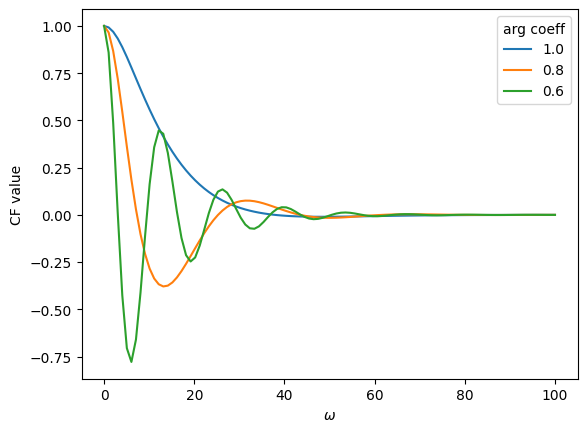

In [36]:
params = HestonParams(0.01, 0.01, 1, 0.2, -0.5)
T = 1

omega = np.linspace(0, 100, 100)
lcf = heston_log_char_func(omega, T, params)

_, ax = plt.subplots()
for coeff in (1.0, 0.8, 0.6):
    ax.plot(omega, np.real(np.exp(lcf + 1j * omega * np.log(coeff))), label=f"{coeff}")
    
ax.set_xlabel("$\omega$")
ax.set_ylabel("CF value")
ax.legend(title="arg coeff")
plt.show()

### Two: Don't let him in

The second idea: don't use the Black-Scholes formula, but the second fundamental theorem:
$$
C 
= e^{-rT} \mathbb{E} C(y) 
= e^{-rT} \int p(t, x, v; y) C(y)\,dy.
$$
In the frequency domain the expectation turns into the multiplication.
We can:
- compute the image of the payoff,
- compute the image of the probability density (characteristic function),
- compute the original of the product.

The straightforward implementation of this idea leads to the __Carr-Madan__ method.

### Three: Don't be his friend

We can use some other transform instead if the Fourier one.

# COS-method

Any function $f(x)$ on $[0,\pi]$ can be evenly expanded on $[-\pi, \pi]$.
The resulting Fourier series have non-zero weights only for $\cos$, so the resulting series are called _cos-series_:
$$
f(x) = \frac{A_0}{2} + \sum_{n=1}^\infty A_n \cos(nx), \qquad
A_n = \frac{2}{\pi}\int_0^\pi f(x) \cos(nx)\,dx,
$$
For functions defined on any segment $[a, b]$ the change of variable is used:
$$
f(x) = \frac{A_0}{2} 
  + \sum_{n=1}^\infty A_n \cos\left(n\pi\frac{x-a}{b-a}\right), \quad
A_n = \frac{2}{b-a}\int_a^b f(x) \cos\left(n\pi\frac{x-a}{b-a}\right) dx.
$$

We can rewrite:
$$
A_n = \frac{2}{b-a}
\mathrm{Re}\left\{
  \tilde\phi\left(\frac{n\pi}{b-a}\right)\exp\left(-i\frac{na\pi}{b-a}\right)
\right\},
$$
where
$$
\tilde\phi(u) = \int_a^b e^{iux} f(x) dx.
$$

If $[a,b]$ is big enough, we can approximate
$$
A_n \approx F_n := \frac{2}{b-a}
\mathrm{Re}\left\{
  \phi\left(\frac{n\pi}{b-a}\right)\exp\left(-i\frac{na\pi}{b-a}\right)
\right\},
$$
where $\phi(u)=\int e^{iux}f(x)\,dx$ is a characteristic function $f(x)$. 

#### Step 1

Choose $[a,b]$ such that
$$
C := e^{-rT}\int_{\mathbb{R}} g(x) f(x) dx 
\approx e^{-rT} \int_{a}^{b} g(x) f(x) dx.
$$

#### Step 2

Expand $f(x)$ and truncate the series:
\begin{multline*}
C \approx e^{-rT} \int_a^b g(x) \biggl(
    \frac{A_0}{2} + \sum_{n=0}^\infty A_n \cos\left(n\pi\frac{x-a}{b-a}\right) 
  \biggr) dx \\
= e^{-rT} \frac{b-a}{2} \left(
    \frac{A_0V_0}{2} + \sum_{n=1}^\infty A_nV_n
  \right)
\approx e^{-rT} \frac{b-a}{2} \left(
    \frac{A_0V_0}{2} + \sum_{n=1}^{N} A_nV_n
  \right),
\end{multline*}
where
$$
V_n = \frac{2}{b-a}\int_a^b g(x) \cos\left(n\pi\frac{x-a}{b-a}\right) dx.
$$

#### Step 3
Approximate $A_n\approx F_n$
$$
C \approx e^{-rT} \frac{b-a}{2} 
\left(\frac{F_0V_0}{2} + \sum_{k=1}^N F_nV_n\right),
$$
where
$$
F_n = \frac{2}{b-a}
\mathrm{Re}\left\{
  \phi_T\left(\frac{n\pi}{b-a}\right)\exp\left(-i\frac{na\pi}{b-a}\right)
\right\}.
$$

### Result:

$$
C\approx e^{-rT} 
\left(\frac{V_0}{2} 
  + \sum_{n=1}^N \mathrm{Re}\left\{ 
    \phi_T\left(\frac{n\pi}{b-a}\right)e^{-in\pi \frac{x(K) - a}{b-a}} 
  \right\} V_n 
\right),
$$
where $x(K) = \log \left(S_0 / K\right)$.

$V_n$ can be found analytically for some payoffs.

## Practical considerations

### Vanilla options:

1. Calculate put price, recover call by parity.
1. Be carefull with the arguments outside the truncation range.
1. How to choose the truncaction range?

### 1. The put option coeffs:

$$
\chi_{k}(c, d) = \frac{1}{1 + \left( \frac{k\pi}{b - a} \right)^{2}} \left[ 
\cos \left( k\pi \frac{d-a}{b-a} \right) e^{d}
- \cos \left( k\pi \frac{c-a}{b-a} \right) e^{c}
+ \frac{k\pi}{b-a} \sin \left( k\pi \frac{d-a}{b-a} \right) e^{d}
- \frac{k\pi}{b-a} \sin \left( k\pi \frac{c-a}{b-a} \right) e^{c}
\right] 
$$

$$
\psi_{k}(c, d) = 
\begin{cases}
\left[ \sin \left( k\pi \dfrac{d-a}{b-a} \right) - \sin \left( k\pi \dfrac{c-a}{b-a} \right)\right] \frac{b-a}{k\pi}, & k \neq 0, \\
d - c, & k = 0.
\end{cases}
$$

$$
V_k^{put} = \frac{2}{b - a} K \left( -\chi_k(a, 0) + \psi_k(a, 0) \right)
$$

__Note__: the coeffs are easily vectorized for different strikes.

### 2. Outside of the range integration

Manually set the option price to its lower bound for options, where $x(K) \notin [a, b]$.

### 3. How to chose $[a, b]$

The original proposition:
$$
[a, b] := \left[ c_{1} - L \sqrt{ c_{2} + \sqrt{ c_{4} }},\quad c_{1} + L \sqrt{ c_{2} + \sqrt{ c_{4} } } \right] \quad \text{with}\ L = 10,
$$
$$
[a, b] := \left[ c_{1} - L \sqrt{ c_{2} + \sqrt{ c_{4} + \sqrt{ c_{6} } }},\quad c_{1} + L \sqrt{ c_{2} + \sqrt{ c_{4} + \sqrt{ c_{6} } } } \right].
$$
where $c_i$ is an $i$-th cumulant of the $x(K)$.
The first one is accurate for $T \in [0.1, 10]$, the second one works for $T = 0.001$, but the higher order cumulants are hard to derive since it requires the differentiating of the logarighm of the CF:
$$
\log \mathbb{E} e^{tX} = \sum_{n=1}^\infty c_n \frac{t^n}{n!}.
$$

The second option was proposed in paper [Precise option pricing by the COS method — How to choose the
truncation range](https://www.sciencedirect.com/science/article/pii/S0096300322000212):

$$
a = -L + \mathbb{E} \log S_T, \qquad a = L + \mathbb{E} \log S_T,
\qquad L = \sqrt[n]{\frac{2 \mu_n K}{\varepsilon}},
$$
where $\mu_n$ is a log-price's $n$-th moment.

In [27]:
def vanilla_put_cos_expansion_coeffs(a: Floats,
                                     b: Floats,
                                     k: int) -> Floats:
    """
    Computes the cosine expansion coefficients of the vanilla put option
    payoff.

    Args:
        a, b: integration bounds for the payoff function
        k: number of coefficients

    Returns:
        vector of coefficients
    """

    ks = np.arange(k)
    a, b = a[..., None], b[..., None]  # new axis for coefficients
    c, d = a, np.zeros_like(a)

    c_frac = ks * np.pi * (c - a) / (b - a)
    d_frac = ks * np.pi * (d - a) / (b - a)

    chi = 1 / (1 + (ks * np.pi / (b - a)) ** 2) * (
        np.cos(d_frac) * np.exp(d) - np.cos(c_frac) * np.exp(c)
        + ks * np.pi / (b - a) * (
            np.sin(d_frac) * np.exp(d) - np.sin(c_frac) * np.exp(c)
        )
    )

    psi = (b - a) / ks[1:] / np.pi * (
        np.sin(d_frac[..., 1:]) - np.sin(c_frac[..., 1:])
    )
    psi = np.insert(psi, 0, np.squeeze(d - c, axis=-1), axis=-1)

    return 2 / (b - a) * (psi - chi)

In [78]:
def calc_trunc_range(eps: float, params: HestonParams, dt: float):
    return np.array(10.)

In [79]:
def price(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    mean_log_s_t = ms.interest_rate * dt
    trunc_range = calc_trunc_range(eps, params, dt)  # half of [a, b]

    x = np.log(ms.stock_price / option.strike_price)
    trunc_lb = mean_log_s_t - trunc_range
    trunc_ub = mean_log_s_t + trunc_range
    x_within_bounds = ((x >= trunc_lb) & (x <= trunc_ub))

    # COS method
    cos_cf = vanilla_put_cos_expansion_coeffs(trunc_lb, trunc_ub, n_points)
    omega = (np.pi / (trunc_ub - trunc_lb))[..., None] * np.arange(n_points)

    df = np.exp(-ms.interest_rate * dt)  # discount factor
    lcf = (
        heston_log_char_func(omega, dt[..., None], params)
        + 1j * (x + mean_log_s_t - trunc_lb)[..., None] * omega
    )
    prod = np.exp(lcf) * cos_cf
    prod[..., 0] /= 2

    put_price = option.strike_price * df * np.real(prod.sum(-1))
    put_price_lb = np.maximum(option.strike_price * df - ms.stock_price, 0.0)

    call_price = put_price + ms.stock_price - option.strike_price * df
    call_price_lb = np.maximum(ms.stock_price - option.strike_price * df, 0.0)

    raw_price = np.where(option.is_call, call_price, put_price)
    price_lb = np.where(option.is_call, call_price_lb, put_price_lb)

    # ensure price fits the lower bound
    # return raw_price
    return np.maximum(
        np.where(x_within_bounds, raw_price, price_lb),
        price_lb,
    )

In [82]:
strikes = np.linspace(40, 200, 50)
time = 0.1

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.0)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

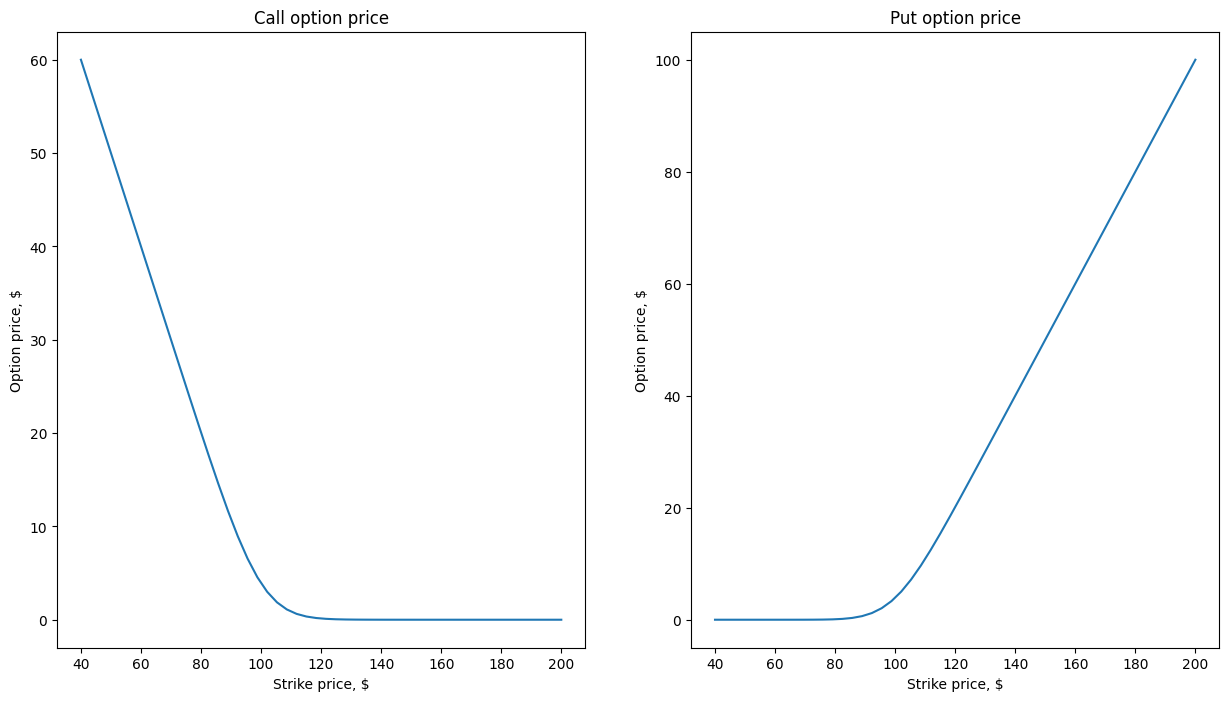

In [83]:
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')

ax2.plot(strikes, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')

plt.show()